In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from itertools import count
from models.unet import unet
from settings import s
import time
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import dataloader
import json


In [85]:
mbsize = 8
report_freq=s.report_freq
weight_path=s.weights_path
lr=s.learning_rate
save_freq = s.save_freq
time_namer = time.strftime("%y%m%d%H%M%S")
load_specific = False
parent_name = None
epochs = s.epochs

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_shape=(3,32,32)
out_shape=(s.classes,32,32)

weight_path_ending=os.path.join(weight_path,time_namer+"_"+s.weights_name)
print("NETWORK PATH:", weight_path_ending)

loss_path_ending = os.path.join(weight_path, time_namer + "_" + s.loss_name)
model_description_path_ending = os.path.join(weight_path,s.model_description_name)
#using the matlab formula: 0.2989 * R + 0.5870 * G + 0.1140 * B 

#transformGray = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#transform = transforms.Compose([transforms.ToTensor()])#,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

trainset = datasets.CIFAR10(root='./cifar-10', train=True,
                                    download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mbsize,
                                      shuffle=True, num_workers=2)

NETWORK PATH: weights\190911184605_unet_test
Files already downloaded and verified


In [34]:
trainset.data.shape

(50000, 32, 32, 3)

In [57]:
#print("dataset_type",dataset_type)
#dataloader
#trainloader=torch.utils.data.DataLoader(dataset,batch_size=mbsize,shuffle=True, num_workers=1)

#define model
UNet=unet().to(device)
#load weights
if not parent_name is None or load_specific:
    try:
        if load_specific:
            UNet.load_state_dict(torch.load(weight_path_ending))
        else:
            UNet.load_state_dict(torch.load(parent_path_ending))
        print("Loaded weights from", parent_path_ending)
    except FileNotFoundError:
        print("Unable to find weight path "+ parent_path_ending + ". Initializing new weights.")
        # weights already initialized in unet.__init__()
else:
    print("No parent network specified. Initialized new weights.")
    #TODO: fix this 
    '''
    # change model overview list:
    if not time_namer in model_dict.keys():
        model_dict[time_namer] = {
            "data_set_path": data_path,
            "loaded_weights": parent_name,
            "epochs": e,
            "batch_size": mbsize,
            "scale": s.scale,
            "crop": s.crop_size,
            "batch_normalization": batch_norm,
            "loss_normalization": loss_norm,
            "lr": lr,
            "betas": s.betas
        }
    else:
        model_dict[time_namer]["epochs"] = e  # only epochs change when model is already mentioned in dict
    with open(model_description_path_ending, "w") as file:
        json.dump(model_dict, file, sort_keys=True, indent=4)'''
UNet.train()
#optimizer
optimizer=optim.Adam(UNet.parameters(),lr=lr,betas=s.betas)
criterion = nn.MSELoss().to(device)

loss_hist=[]

# initialize model dict
try:
    with open(model_description_path_ending, "r") as file:
        model_dict = json.load(file)
except FileNotFoundError:
    model_dict = {}



No parent network specified. Initialized new weights.


In [58]:
#convert to black and white image using following weights
gray = torch.tensor([0.2989 ,0.5870, 0.1140 ])[:,None,None].float()
# run over epochs
for e in (range(epochs) if not s.infinite_loop else count()):
    #load batches
    for i,(image,c) in enumerate(trainloader):
        #clear gradients
        optimizer.zero_grad()
        #convert to grayscale image
        
        #using the matlab formula: 0.2989 * R + 0.5870 * G + 0.1140 * B and load data to gpu
        X=(image.clone()*gray).sum(1).to(device).view(-1,1,*in_shape[1:])
        image=image.float().to(device)
        #generate colorized version with unet
        unet_col=UNet(X)
        #calculate loss
        loss=criterion(unet_col, image)
        #backpropagation
        loss.backward()
        loss_hist.append([e,i,loss.item()])
        optimizer.step()
        #report loss
        if (i+len(trainloader)*e)%report_freq==report_freq-1:
            print('Epoch %i, batch %i: loss=%.2e'%(e+1,i+1,
            loss.item()))#np.convolve(loss_hist, np.ones((s.batch_size,))/s.batch_size, mode='valid')))
        if s.save_weights and (i+len(trainloader)*e)%save_freq==save_freq-1:
            #save parameters
            try:
                torch.save(UNet.state_dict(),weight_path_ending)
            except FileNotFoundError:
                os.makedirs(weight_path)
                torch.save(UNet.state_dict(),weight_path_ending)
            print("saved parameters")
            if s.save_loss:
                #save loss history to file
                try:
                    f=open(loss_path_ending,'a')
                    np.savetxt(f,loss_hist,'%e')
                    f.close()
                except FileNotFoundError:
                    os.makedirs(s.loss_path)
                    np.savetxt(loss_path_ending,loss_hist,'%e')
                loss_hist=[]


Epoch 1, batch 10: loss=3.54e-02
Epoch 1, batch 20: loss=1.59e-02
Epoch 1, batch 30: loss=9.95e-03
Epoch 1, batch 40: loss=7.96e-03


KeyboardInterrupt: 

In [4]:
un=unet()
un.state_dict()

OrderedDict([('input.double_conv.0.weight',
              tensor([[[[-8.6663e-02,  5.9201e-02,  6.5406e-02],
                        [-4.5270e-02,  2.7067e-02,  1.5981e-02],
                        [-2.2624e-02,  2.2830e-03, -1.1621e-02]]],
              
              
                      [[[ 7.4971e-03, -4.0665e-02, -9.5702e-02],
                        [-1.0258e-01,  7.0541e-02,  2.7668e-02],
                        [ 5.5302e-02, -2.6427e-02,  1.0026e-01]]],
              
              
                      [[[ 6.4967e-02,  7.4669e-02,  1.0442e-01],
                        [ 2.1975e-02,  4.3031e-02, -5.7790e-02],
                        [-6.6185e-03, -2.0047e-02, -2.6862e-02]]],
              
              
                      [[[-1.1918e-02, -4.8519e-02,  1.1585e-02],
                        [ 3.9195e-02,  5.7437e-02,  9.6924e-02],
                        [-4.8877e-02, -2.1914e-02, -2.6921e-02]]],
              
              
                      [[[ 3.7172e-02,  7.0789e-0

In [7]:
torch.save(un.state_dict(),'weights/test.pth')

In [8]:
un.load_state_dict(torch.load('weights/test.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
tt2=trainloader.dataset.data[:6]
tt2

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [23]:
torch.from_numpy(tt2).shape

torch.Size([6, 32, 32, 3])

In [28]:
tttt2=(torch.from_numpy(tt2)*torch.tensor([0.2989 ,0.5870, 0.1140 ])[None,None,None,:].byte()).sum(0)
tttt2.shape

torch.Size([6, 32, 32])

In [76]:
torch.tensor([1,2,3])[None,None,:].shape

torch.Size([1, 1, 3])

In [4]:
tt=trainloader.dataset.data[0]
import matplotlib.pyplot as plt

In [49]:
tt.shape

(32, 32, 3)

In [36]:
ttt=transformGray(tt)

In [50]:
type(tt)

numpy.ndarray

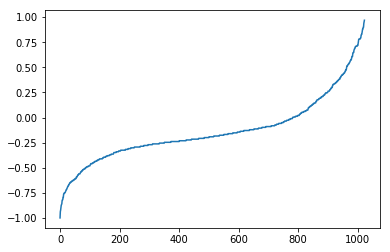

In [43]:
plt.plot(sorted(ttt.flatten()))

In [62]:
transforms.T

(32, 32, 3)

In [29]:
plt.imshow(transforms.ToPILImage()(tttt2[0]),cmap='gray')

TypeError: Input type int64 is not supported

In [31]:
tttt2[0].max()

tensor(0)

In [33]:
a=torch.arange(150).view(2,3,5,5)
a

tensor([[[[  0,   1,   2,   3,   4],
          [  5,   6,   7,   8,   9],
          [ 10,  11,  12,  13,  14],
          [ 15,  16,  17,  18,  19],
          [ 20,  21,  22,  23,  24]],

         [[ 25,  26,  27,  28,  29],
          [ 30,  31,  32,  33,  34],
          [ 35,  36,  37,  38,  39],
          [ 40,  41,  42,  43,  44],
          [ 45,  46,  47,  48,  49]],

         [[ 50,  51,  52,  53,  54],
          [ 55,  56,  57,  58,  59],
          [ 60,  61,  62,  63,  64],
          [ 65,  66,  67,  68,  69],
          [ 70,  71,  72,  73,  74]]],


        [[[ 75,  76,  77,  78,  79],
          [ 80,  81,  82,  83,  84],
          [ 85,  86,  87,  88,  89],
          [ 90,  91,  92,  93,  94],
          [ 95,  96,  97,  98,  99]],

         [[100, 101, 102, 103, 104],
          [105, 106, 107, 108, 109],
          [110, 111, 112, 113, 114],
          [115, 116, 117, 118, 119],
          [120, 121, 122, 123, 124]],

         [[125, 126, 127, 128, 129],
          [130, 131, 132, 

In [41]:
(a*torch.tensor([1,2,3])[None,:,None,None].long()).sum(1)

tensor([[[200, 206, 212, 218, 224],
         [230, 236, 242, 248, 254],
         [260, 266, 272, 278, 284],
         [290, 296, 302, 308, 314],
         [320, 326, 332, 338, 344]],

        [[650, 656, 662, 668, 674],
         [680, 686, 692, 698, 704],
         [710, 716, 722, 728, 734],
         [740, 746, 752, 758, 764],
         [770, 776, 782, 788, 794]]])

In [38]:
a.shape,torch.tensor([1,2,3])[None,:,None,None].shape

(torch.Size([2, 3, 5, 5]), torch.Size([1, 3, 1, 1]))

In [16]:
np.arange(1,13).reshape(4,3)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [47]:
class critic(nn.Module):
    def __init__(self,im_size):
        super(critic,self).__init__()

        self.cnn=nn.Sequential(convBlock(3,16),
                               convBlock(16,32),
                               convBlock(32,64),
                               convBlock(64,128))
        proc_im_size=im_size//(2**4)
        self.fc=nn.Linear(128*proc_im_size**2,1)
        self.sig=nn.Sigmoid()
        
    def forward(self,x):
        x=self.cnn(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return self.sig(x)
class convBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,stride=2,padding=1):
        super(convBlock,self).__init__()

        self.block=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
                                 nn.LeakyReLU(.2,True),
                                 nn.BatchNorm2d(out_channels),
                                 nn.Dropout2d(.25))
    def forward(self,x):
        return self.block(x)

In [48]:
c=critic(512)
c

critic(
  (cnn): Sequential(
    (0): convBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout2d(p=0.25)
      )
    )
    (1): convBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout2d(p=0.25)
      )
    )
    (2): convBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout2d(p=0.25)
      )
    )
    (3): convBlock(
    

In [56]:
x=torch.rand(64,3,512,512)
c(x).transpose(0,1).shape

torch.Size([1, 64])

In [50]:
import torchsummary.torchsummary as ts
ts.summary(c,(3,512,512),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
         LeakyReLU-2         [-1, 16, 256, 256]               0
       BatchNorm2d-3         [-1, 16, 256, 256]              32
         Dropout2d-4         [-1, 16, 256, 256]               0
         convBlock-5         [-1, 16, 256, 256]               0
            Conv2d-6         [-1, 32, 128, 128]           4,640
         LeakyReLU-7         [-1, 32, 128, 128]               0
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         Dropout2d-9         [-1, 32, 128, 128]               0
        convBlock-10         [-1, 32, 128, 128]               0
           Conv2d-11           [-1, 64, 64, 64]          18,496
        LeakyReLU-12           [-1, 64, 64, 64]               0
      BatchNorm2d-13           [-1, 64, 64, 64]             128
        Dropout2d-14           [-1, 64,

In [52]:
torch.ones(3,).dtype

torch.float32

In [16]:
# implement lab color space
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [17]:
#nice horse
im=trainloader.dataset.data[7]

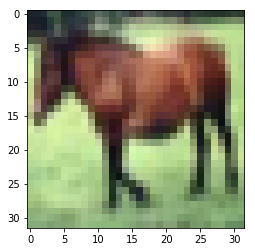

In [18]:
plt.imshow(im)

In [19]:
from skimage import color

lab = color.rgb2lab(im)
x = torch.from_numpy(lab)


In [7]:
manual_c=(im*np.array([0.2989 ,0.5870, 0.1140 ])).sum(2)

In [20]:
def minmax(x):
    if len(x.shape)<=2:
        return x.min(),x.max(),x.mean()
    else:
        t=[]
        for i in range(x.shape[-1]):
            t.append((x[...,i].min(),x[...,i].max(),x[...,i].mean()))
        return tuple(t)

In [50]:
ranges=np.array([100,255,255])
offset=-np.array([0,128,128])
#ranges=np.array([1,1,1])
#offset=np.array([0,0,0])

In [133]:
(lab-color.rgb2lab(im/255)).max()

5.684341886080802e-14

In [134]:
lab[:,:,0].mean()

54.496509510542836

((0.5153743760373749, 0.9, 0.751752744464455), (0.6105159929503754, 0.9, 0.8470231307273118), (0.21204928567513862, 0.9, 0.48854675834644956))


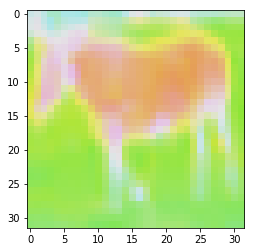

In [135]:
from skimage import exposure
ab=color.lab2rgb(np.concatenate((100*np.ones((32,32,1)),lab[:,:,1:]),axis=2))
exab=exposure.adjust_gamma(ab,4,.9)
#exab=exposure.adjust_log(exab,.8)
print(minmax(exab))
#minmax(exab)
plt.imshow(exab)
#plt.imshow((im-lab[...,0,None])/255)
#plt.colorbar()


In [136]:
(minmax((lab-offset[None,None,:])/ranges))

((0.040935124927035174, 0.9447742623334736, 0.5449650951054283),
 (0.38994192637339864, 0.623781599951578, 0.47869289481729893),
 (0.4669362085952776, 0.6540391292438122, 0.5793812485238722))

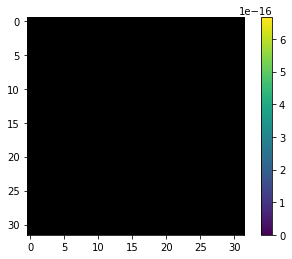

In [27]:
labsc=(lab-offset[None,None,:])/ranges[None,None,:]
plt.imshow(abs(color.lab2rgb(ranges[None,None,:]*labsc+offset[None,None,:])-im/255))
plt.colorbar()
#abs(color.lab2rgb(ranges[None,None,:]*labsc+offset[None,None,:])-im/255)

In [19]:
L,a,b=[],[],[]
for i in range(1,200):
    #image=trainloader.dataset.data[i]
    try:
        image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
    except FileNotFoundError:
        continue
    labim=color.rgb2lab(image)
    labim=(labim-offset[None,None,:])/ranges[None,None,:]
    for i in range(3):
        c=(L,a,b)[i]
        c.append(minmax(labim)[i])
        #c.append(minmax(labim)[i])    

In [20]:
for c in (L,a,b):
    c=np.array(c)
    print('min %.2f max %.2f\t'%(c.min(0)[0],c.max(0)[1]),'max range:',abs(c.min(0)[0]-c.max(0)[1]))#,'mean:',c.mean(0)[2],'std:',(c[0]-c[1]).std())

min 0.00 max 1.00	 max range: 1.0
min 0.19 max 0.88	 max range: 0.6874694164983169
min 0.12 max 0.87	 max range: 0.7521110432693825


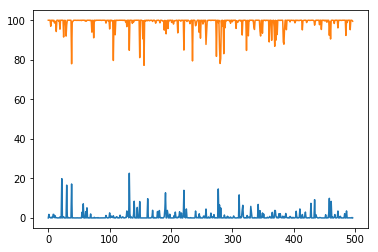

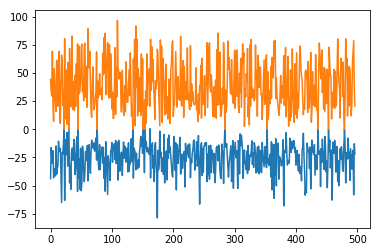

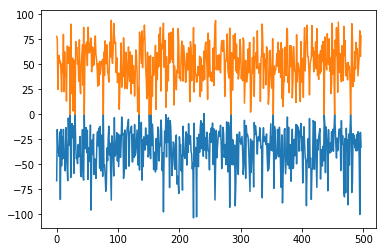

In [252]:
for c in (L,a,b):
    c=np.array(c)
    plt.figure()
    plt.plot(c[:,0])
    plt.plot(c[:,1])    

In [189]:
white=np.random.randint(0,256,((256, 256, 3)))/255
#print(minmax(white))
(white-color.lab2rgb(color.rgb2lab(white))).mean()

-5.866458499160928e-17

In [187]:
pla=plt.imread('places-test/Places365_val_00000001.jpg')/255
minmax(color.rgb2lab(pla))
#(pla-color.lab2rgb(color.rgb2lab(pla))).mean()

((0.0, 100.0, 53.30885789598529),
 (-43.773416849137995, 44.15629705346058, -0.11543877735996289),
 (-66.4667351197716, 77.9235171819431, 5.717888724984579))

In [120]:
minmax((lab/ranges)[:,:,1])

(-0.11201885794032684, 0.12182081563785252, -0.0232678894964266)

In [99]:
import torchvision.transforms as trafo
norm= trafo.Compose([trafo.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [100]:
norm(torch.tensor(np.transpose(lab,(2,0,1))).cuda().double())

RuntimeError: expected backend CUDA and dtype Double but got backend CUDA and dtype Float

In [59]:
minmax(lab[:,:,1])

(-28.564808774783344, 31.06430798765239, -5.933311821588785)

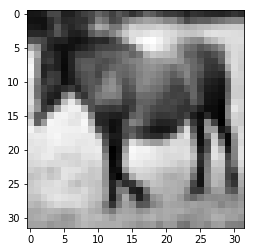

In [40]:

plt.imshow(manual_c,cmap='gray')

In [ ]:
manual_c.max(),lab[:,:,0].max()

In [50]:
(manual_c-lab[:,:,0]*2.55).min()

-15.890016620379384

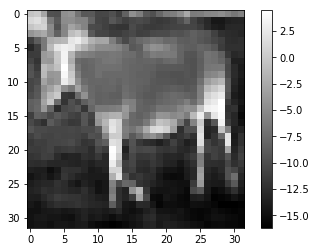

In [51]:
plt.imshow(manual_c-lab[:,:,0]*2.55,cmap='gray')
plt.colorbar()

In [ ]:
from skimage import io, color
class MyData(Dataset):
    ...
    def __getitem__(self, index):
        rgb = io.imread(self.images[index])
        lab = color.rgb2lab(rgb)
        x = torch.from_numpy(lab)
 

In [215]:
for i,(image,c) in enumerate(trainloader):
    print(image.shape)
    break

torch.Size([256, 3, 32, 32])


In [229]:
im.shape

(32, 32, 3)

In [228]:
tes=color.rgb2lab(np.stack((im/255,im/255)))
for i in range(tes.shape[0]):
    print(minmax(tes[i]))
    print((color.lab2rgb(tes[i])-im/255).mean())

((4.093512492703518, 94.47742623334736, 54.496509510542836), (-28.564808774783344, 31.06430798765239, -5.933311821588783), (-8.931266808204203, 38.77997795717212, 19.742218373587406))
2.821184402988323e-17
((4.093512492703518, 94.47742623334736, 54.496509510542836), (-28.564808774783344, 31.06430798765239, -5.933311821588783), (-8.931266808204203, 38.77997795717212, 19.742218373587406))
2.821184402988323e-17


In [238]:
np.arange(np.prod((3,32,32))).reshape(3,32,32)*np.array([1,2,5])[:,None,None]

array([[[    0,     1,     2, ...,    29,    30,    31],
        [   32,    33,    34, ...,    61,    62,    63],
        [   64,    65,    66, ...,    93,    94,    95],
        ...,
        [  928,   929,   930, ...,   957,   958,   959],
        [  960,   961,   962, ...,   989,   990,   991],
        [  992,   993,   994, ...,  1021,  1022,  1023]],

       [[ 2048,  2050,  2052, ...,  2106,  2108,  2110],
        [ 2112,  2114,  2116, ...,  2170,  2172,  2174],
        [ 2176,  2178,  2180, ...,  2234,  2236,  2238],
        ...,
        [ 3904,  3906,  3908, ...,  3962,  3964,  3966],
        [ 3968,  3970,  3972, ...,  4026,  4028,  4030],
        [ 4032,  4034,  4036, ...,  4090,  4092,  4094]],

       [[10240, 10245, 10250, ..., 10385, 10390, 10395],
        [10400, 10405, 10410, ..., 10545, 10550, 10555],
        [10560, 10565, 10570, ..., 10705, 10710, 10715],
        ...,
        [14880, 14885, 14890, ..., 15025, 15030, 15035],
        [15040, 15045, 15050, ..., 15185, 151

In [14]:
from skimage import color

In [267]:

#define range correctly (only the number in the back. zeros are added automatically)
for i in range(1,100):
    try:
        #use correct path
        image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
    except FileNotFoundError:
        continue
    labim=color.rgb2lab(image)
    if labim[:,:,1].max()<2e-1 or labim[:,:,2].max()<2e-1:
        print(i)
        #can delete image here...

23
31
47
78


In [266]:
try:
    image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
except FileNotFoundError:
    ...
labim=color.rgb2lab(image)
labim

(256, 256, 3)

(256, 256, 3)

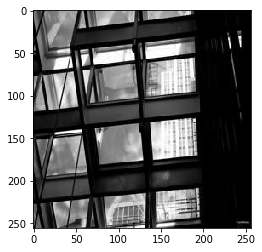

In [69]:
i=78
plt.imshow(plt.imread('places-test/Places365_val_%08d.jpg'%i))
plt.imread('places-test/Places365_val_%08d.jpg'%i).shape

In [77]:
torchsummary.summary(c,(4,256,256),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 129, 129]             272
         LeakyReLU-2         [-1, 16, 129, 129]               0
       BatchNorm2d-3         [-1, 16, 129, 129]              32
         Dropout2d-4         [-1, 16, 129, 129]               0
         convBlock-5         [-1, 16, 129, 129]               0
            Conv2d-6           [-1, 32, 65, 65]           2,080
         LeakyReLU-7           [-1, 32, 65, 65]               0
       BatchNorm2d-8           [-1, 32, 65, 65]              64
         Dropout2d-9           [-1, 32, 65, 65]               0
        convBlock-10           [-1, 32, 65, 65]               0
           Conv2d-11           [-1, 64, 33, 33]           8,256
        LeakyReLU-12           [-1, 64, 33, 33]               0
      BatchNorm2d-13           [-1, 64, 33, 33]             128
        Dropout2d-14           [-1, 64,

In [78]:
cri=torch.nn.BCELoss()

In [96]:
cri(torch.Tensor(6,1,18,18).uniform_(0, 1),torch.Tensor(6,1,18,18).uniform_(0, 1))

tensor(0.9773)

In [147]:
l=nn.ConvTranspose2d(512,256,2,stride=2)
x=torch.empty(1,512,32,32)
l(x).shape

torch.Size([1, 256, 64, 64])

In [679]:
from models.unet import double_conv

In [680]:
# Upsampling with Transposed Convolution
class up_conv(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(up_conv,self).__init__()
        # half the channels, double the resolution
        #first to save gpu mem
        #self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.upsample=nn.ConvTranspose2d(in_channels,out_channels,2,stride=2)
        #self.double_conv = double_conv(out_channels,out_channels)
    # takes two inputs: one from the skip connection and the other from
    # the last convolutional layer
    def forward(self,x):
        #first upsampling
        x=self.upsample(x)
        # concatenate skip-connection and x
        #x=torch.cat([skip,x],dim=1)
        #x=self.double_conv(x)
        return x



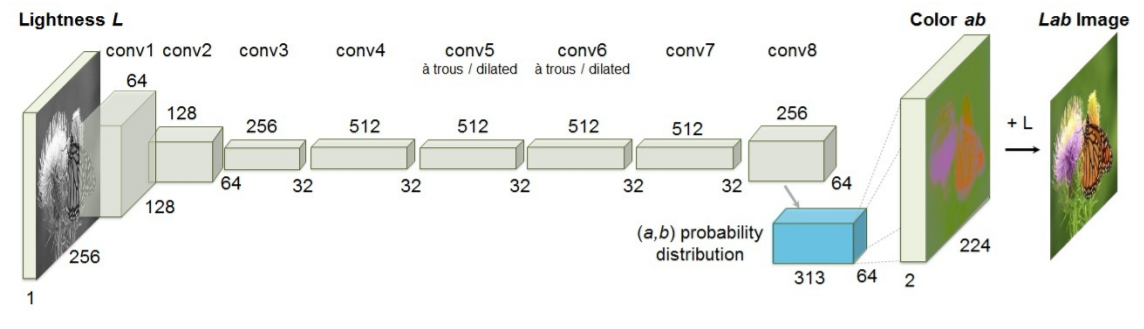

encoder: C64-C128-C256-C512-C512-C512-C512-C512

decoder: CD512-CD512-CD512-C512-C256-C128-C64

In [13]:

class richzhang(nn.Module):
    def __init__(self, drop_rate=0, classes=274):
        '''
        This network is similar to the unet but misses the skip connections. In return we can make the network deeper 
        while using the same amount of gpu ram.
        '''
        self.classes=classes
        super(richzhang,self).__init__()

        #encoder and decoder architecutres
        
        self.encoder = nn.Sequential(conv_block(1,64,1,3,1,1,drop_rate=drop_rate),conv_block(64,64,1,3,1,1,drop_rate=drop_rate),conv_block(64,64,1,3,2,1,bn=True,drop_rate=drop_rate),
                                    conv_block(64,128,1,3,1,1,drop_rate=drop_rate),conv_block(128,128,1,3,2,1,bn=True,drop_rate=drop_rate),
                                    conv_block(128,256,1,3,1,1,drop_rate=drop_rate),conv_block(256,256,1,3,1,1,drop_rate=drop_rate),conv_block(256,256,1,3,2,1,bn=True,drop_rate=drop_rate),
                                    conv_block(256,512,1,3,1,1,drop_rate=drop_rate),conv_block(512,512,1,3,1,1,num=2,bn=True,drop_rate=drop_rate),
                                    conv_block(512,512,2,3,1,2,num=3,bn=True,drop_rate=drop_rate))
                                    
        
        self.decoder = nn.Sequential(conv_block(512,512,2,3,1,2,num=3,bn=True,drop_rate=drop_rate),conv_block(512,512,1,3,1,1,num=3,bn=True,drop_rate=drop_rate),
                                    up_conv(512,256,1,4,2),conv_block(256,256,1,3,1,1,num=2,bn=True,drop_rate=drop_rate),
                                    conv_block(256,classes,0,1,1,1,drop_rate=drop_rate))
        self.out = nn.Softmax(1)
        # initializing weights:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    def forward(self, x):
        # contraction
        x = self.encoder(x)
        # expansion
        x = self.decoder(x)
        return self.out(x)
    
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels,pad=1,kernel=3, stride=2,dil=1, drop_rate=0, bn=False, leaky=None, num=1):
        super(conv_block,self).__init__()
        self.layer_list = [
                nn.Conv2d(in_channels, out_channels, kernel, stride, pad, dil),
                nn.ReLU(inplace=True) if leaky is None else nn.LeakyReLU(leaky,True)] * num
        
        if bn:
            self.layer_list.append(nn.BatchNorm2d(out_channels))
        if drop_rate > 0:
            self.layer_list.append(nn.Dropout2d(drop_rate))

        self.convs = nn.Sequential(*self.layer_list)

    def forward(self, x):
        x = self.convs(x)
        return x
# Upsampling with Transposed Convolution
class up_conv(nn.Module):
    def __init__(self, in_channels,out_channels,pad=1,kernel=3, stride=2,leaky=None):
        super(up_conv,self).__init__()
        # half the channels, double the resolution
        #first to save gpu mem
        #self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.upsample=nn.ConvTranspose2d(in_channels,out_channels,kernel,stride,pad)
        self.relu=nn.ReLU(inplace=True) if leaky is None else nn.LeakyReLU(leaky,True)

    def forward(self,x):
        x=self.upsample(x)
        return self.relu(x)

In [185]:
g=richzhang()#.cuda()
print(g)

richzhang(
  (encoder): Sequential(
    (0): conv_block(
      (convs): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
    )
    (1): conv_block(
      (convs): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
    )
    (2): conv_block(
      (convs): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): conv_block(
      (convs): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
    )
    (4): conv_block(
      (convs): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace)
        (2): BatchNorm2d(128, eps=1e-05, mo

In [10]:
from torchsummary.torchsummary import summary

In [11]:
o=g(torch.Tensor(lab[:,:,:1].reshape(1,1,32,32)).cuda())

In [64]:
zoom(o,(4,4,1))

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [61]:
summary(g.cuda(),(1,32,32),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
              ReLU-2           [-1, 64, 32, 32]               0
        conv_block-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
        conv_block-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]          36,928
              ReLU-8           [-1, 64, 16, 16]               0
       BatchNorm2d-9           [-1, 64, 16, 16]             128
       conv_block-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
             ReLU-12          [-1, 128, 16, 16]               0
       conv_block-13          [-1, 128, 16, 16]               0
           Conv2d-14            [-1, 12

In [721]:
#l=nn.Conv2d(64,32, 3, 1/2, 1)
x=torch.empty(1,1,224,224).cuda()
g(x).shape


torch.Size([1, 274, 56, 56])

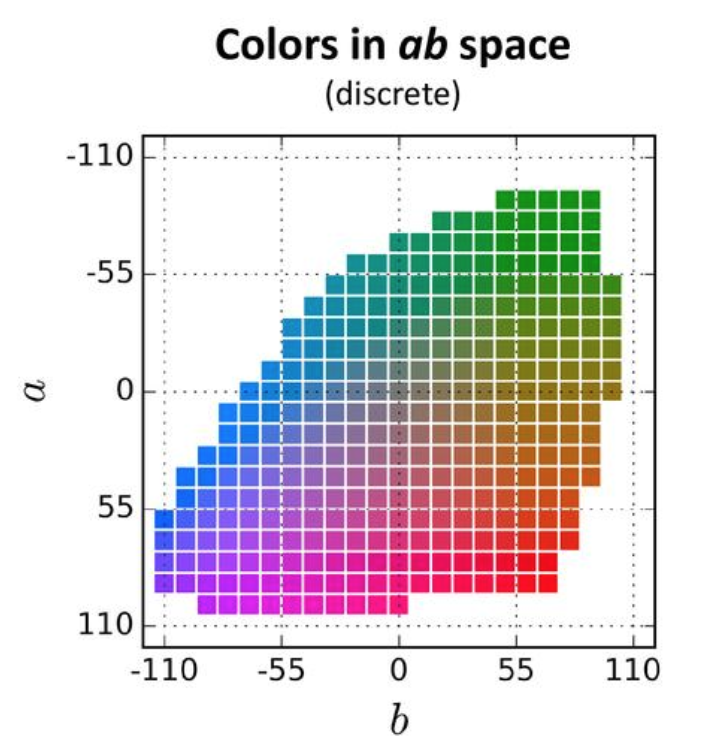

In [58]:
x=np.linspace(-110,110,23,True,dtype=int)
g=x*np.ones((1,len(x))).T
g=np.stack((g,np.rot90(g)))

In [59]:
import matplotlib.pyplot as plt
from skimage import color

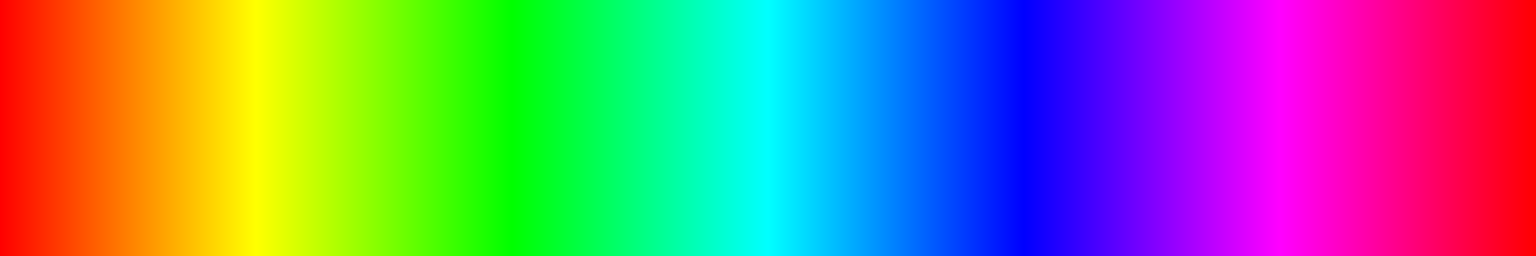

In [60]:
from PIL import Image
spectrum = np.zeros([256,256*6, 3], dtype=np.uint8) # init the array
# fill the array with rgb values to create the spectrum without the use of loops
spectrum[:,:,0] = np.concatenate(([255]*256, np.linspace(255,0,256), [0]*256, [0]*256, np.linspace(0,255,256), [255]*256), axis=0)
spectrum[:,:,1] = np.concatenate((np.linspace(0,255,256), [255]*256, [255]*256, np.linspace(255,0,256), [0]*256,[0]*256), axis=0)
spectrum[:,:,2] = np.concatenate(([0]*256, [0]*256,np.linspace(0,255,256),[255]*256, [255]*256, np.linspace(255,0,256)), axis=0)
img = Image.fromarray(spectrum, 'RGB')
img

In [61]:
labspec=color.rgb2lab(spectrum/255)[0]

In [62]:
gridlab=np.vstack(map(np.ravel, np.meshgrid(x,x))).T

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [63]:
#for c in np.linspace(0,100,1):
from skimage.transform import pyramid_expand
L=np.ones((1,len(x),len(x)))*50
labspace=np.concatenate((L,g)).transpose(2,1,0)
labspace=np.fliplr(labspace)



In [64]:
for a,b in zip(labspace[:,:,1].flatten(),labspace[:,:,2].flatten()):
    if np.count_nonzero(np.logical_and(labspec[:,1]<=a , labspec[:,1] >= a+10))>0 and  np.count_nonzero(np.logical_and(labspec[:,2]<= b ,labspec[:,2] >= b+10))>0:
        print(a,b)

In [65]:
xg = np.linspace(-110,110,23,True)
xg

array([-110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,
        -20.,  -10.,    0.,   10.,   20.,   30.,   40.,   50.,   60.,
         70.,   80.,   90.,  100.,  110.])

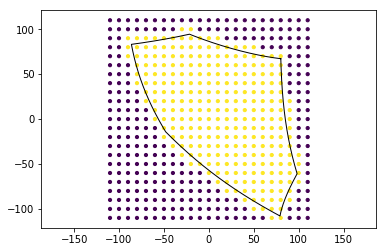

(274, 2) 274


In [66]:
from matplotlib import path
import matplotlib.pyplot as plt
import numpy as np

first = -110
size  = (110-first)/100

xv,yv = np.meshgrid(x,x)# np.meshgrid(np.linspace(-110,110,100),np.linspace(-110,110,100))
#p = path.Path([(-30,-10), (-50, 20), (10, 10), (30, 0)])  # square with legs length 1 and bottom left corner at the origin
p=path.Path(labspec[:,1:][::-1])
flags = p.contains_points(np.hstack((xv.flatten()[:,np.newaxis],yv.flatten()[:,np.newaxis])),radius=-15)
grid = np.zeros((101,101),dtype='bool')
grid[((xv.flatten()-first)/size).astype('int'),((yv.flatten()-first)/size).astype('int')] = flags

#xi,yi = np.random.randint(-300,300,100)/3,np.random.randint(-300,300,100)/3
xi,yi=gridlab[:,0],gridlab[:,1]
vflag = grid[((xi-first)/size).astype('int'),((yi-first)/size).astype('int')]
#plt.imshow(grid.T,origin='lower',interpolation='nearest',cmap='binary',extent=[-labspace.shape[1]*5., labspace.shape[1]*5., -labspace.shape[0]*5., labspace.shape[0]*5. ])
#plt.scatter(((xi-first)/size).astype('int'),((yi-first)/size).astype('int'),c=vflag,s=10)
plt.scatter(xi,yi,c=vflag,s=10)
plt.axis('equal')
plt.plot(labspec[:,1],labspec[:,2],color='k',lw=1)
plt.show()
print(labspace[flags.reshape(23,23)][:,1:].shape,np.count_nonzero(flags))

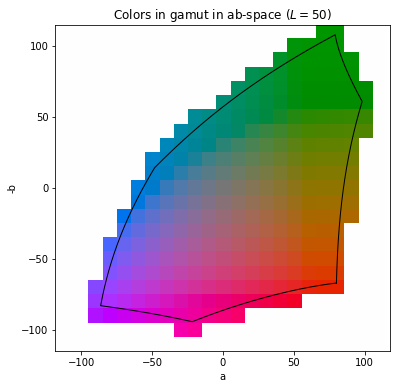

In [49]:
plt.figure(figsize=(6,6))
L=np.ones((1,len(x),len(x)))*50
labspace=np.concatenate((L,g)).transpose(2,1,0)
labspace=np.fliplr(labspace)
labspace_w=np.ones_like(labspace)*np.array([100,0,0]).reshape(1,1,3)
labspace_w[vflag.reshape(len(x),len(x))]=labspace[vflag.reshape(len(x),len(x))]
rgbrep=color.lab2rgb(pyramid_expand(labspace_w,10,0,0))
#rgbrep[rgbrep==np.zeros(3)]=np.ones_like(np.count_nonzero(rgbrep==np.zeros(3)))
plt.imshow(rgbrep,extent=[-labspace.shape[1]*5., labspace.shape[1]*5., -labspace.shape[0]*5., labspace.shape[0]*5. ])
#plt.plot(labspecfromxyz[:,1]+127,127+labspecfromxyz[:,2],color='k',lw=1)
plt.plot(labspec[:,1],-labspec[:,2],color='k',lw=1)
plt.axis('equal')
#plt.gca().grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.xlabel('a')
plt.ylabel('-b')
plt.title('Colors in gamut in ab-space $(L=%i)$'%L.flatten()[0])
#plt.savefig('figures/labgamut-bins.pdf')
plt.show()

In [251]:
np.count_nonzero(color.lab2rgb(pyramid_expand(labspace_w,10,0,0))==np.zeros(3))

15100

In [85]:
sp=color.xyz2lab(cxy[:,1:][None,None,:])[0,0]

In [83]:
cxy=np.loadtxt('resources/cccie64_1.csv',delimiter=',')

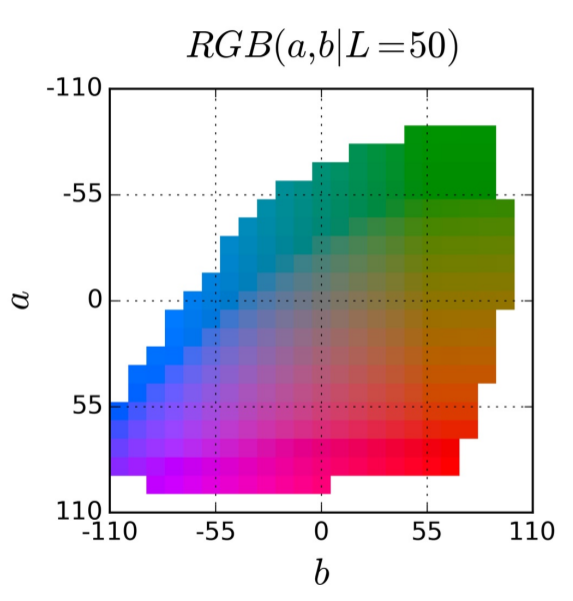

In [159]:
#np.where(labspace_w!=0)
labspace[vflag.reshape(22,22)][:,1:].size

444

In [259]:
bins=labspace[vflag.reshape(22,22)][:,1:]
len(bins)

274

In [260]:
norm_bins=(bins[None,:]+128)/255

In [261]:
np.save('resources/bins.npy',bins)
np.save('resources/norm_bins.npy',norm_bins)

In [5]:
bins=np.load('resources/bins.npy')

In [6]:
def dist_mat(X,Y):
    dists = -2 * np.dot(X, Y.T) + np.sum(Y**2,    axis=1) + np.sum(X**2, axis=1)[:, np.newaxis]
    return dists

In [448]:
from tqdm import tqdm
#histogram for color rarity
#hist=dict(enumerate(np.zeros(len(bins))))
for i in tqdm(range(1,len(trainloader.dataset.data))):
    #image=trainloader.dataset.data[i]
    try:
        #image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
        image=trainloader.dataset.data[i]/255
    except FileNotFoundError:
        continue
    labim=color.rgb2lab(image)
    used_bins=dist_mat(bins,labim[:,:,1:].reshape(-1,2)).argmin(0)
    for j in range(len(used_bins)):
        hist[used_bins[j]]+=1



100%|██████████████████████████████████████████████████████████████████████████▉| 49997/50000 [06:11<00:00, 134.00it/s]

IndexError: index 50000 is out of bounds for axis 0 with size 50000

100%|██████████████████████████████████████████████████████████████████████████▉| 49997/50000 [06:30<00:00, 134.00it/s]

In [479]:
from scipy.ndimage import gaussian_filter

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


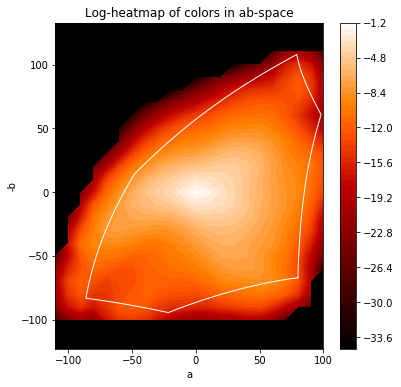

In [508]:
plt.figure(figsize=(6,6))
ind=(bins/10+11).astype(int)
val=np.array(list(hist.values()))
#val=val/(val.sum())
heigth_map=np.ones((22,22))*0
for i in range(len(bins)):
    heigth_map[ind[i][0],ind[i][1]]=val[i]
heigth_map=gaussian_filter(heigth_map,.5)
plt.contourf(xv,-yv,np.log((heigth_map/heigth_map.sum())),60,cmap='gist_heat',extent=[-labspace.shape[1]*5., labspace.shape[1]*5., -labspace.shape[0]*5., labspace.shape[0]*5. ])
plt.plot(labspec[:,1],-labspec[:,2],color='w',lw=1)
plt.axis('equal')
#plt.gca().grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.gca().set_facecolor('black')
plt.xlabel('a')
plt.ylabel('-b')
plt.title('Log-heatmap of colors in ab-space')
plt.colorbar()
#plt.savefig('figures/labgamut-histogram.pdf')
plt.show()

In [512]:
#save values
histval=np.array(list(hist.values()))
for i in range(len(bins)):
    histval[i]=heigth_map[ind[i][0],ind[i][1]]
    #print(heigth_map[ind[i][0],ind[i][1]])
#add offset
#histval+=1
np.save('resources/hist_val.npy',histval)

In [7]:
def torch_dist_mat(X,Y):
    #print(X.shape,Y.shape,torch.matmul(X, torch.transpose(Y,1,2).double()).shape,torch.sum(Y**2,dim=2).shape,(torch.sum(X**2, dim=2)[:,None]).shape)
    #print((torch.sum(Y**2,dim=2).double()[:,None] + torch.sum(X**2, dim=2)).shape)
    return -2 * torch.matmul(X, torch.transpose(Y,1,2).double()) + torch.sum(Y**2,dim=2).double()[:,None] +torch.unsqueeze(torch.sum(X**2, dim=2),2)  

In [8]:
def dist_mat(X,Y):
    return -2 * X@Y.T + np.sum(Y**2, axis=1) + np.sum(X**2, axis=1)[:, None]

In [9]:
tbins=torch.unsqueeze(torch.from_numpy(bins),0)

In [10]:
def ab2bins(image):
    #takes image with only ab channels and returns the 
    shape=image.shape
    im_size=shape[2 if len(shape)==4 else 1]
    mbsize = shape[0] if len(shape)==4 else 1
    if type(image)==torch.Tensor:
        bin_rep = torch_dist_mat(tbins,image.reshape(mbsize,-1,2)).argmin(1).reshape(mbsize,1,im_size,-1)
        if len(shape)==4:
            return bin_rep
        else:
            return bin_rep[0]
    else:
        image=np.array(image)
        bin_rep = dist_mat(bins,image.reshape(-1,2)).argmin(0).reshape(mbsize,im_size,-1,1)
        if len(shape)==4:
            return bin_rep
        else:
            return bin_rep[0]

In [335]:
lten=torch.from_numpy(lab[:,:,1:])#.reshape(1,2,32,32)
lten=lten.transpose(0,2).unsqueeze(0)

In [834]:
torch.unsqueeze(torch.sum(tbins**2, dim=2),2).shape

torch.Size([1, 274, 1])

In [348]:
bmap=np.ones((22,22))*-1
bc=(bins/10).astype(int)
bmap[bc[:,0],bc[:,1]]=np.arange(len(bins))
torch.save(torch.from_numpy(bmap).long(),'resources/binmap.pt')

In [349]:
bmap=torch.load('resources/binmap.pt')

In [357]:
lten.shape

torch.Size([1, 2, 32, 32])

In [350]:
ind=torch.round(lten/10).long()
b=bmap[ind[:,0,:,:],ind[:,1,:,:]]

In [340]:
b=ab2bins(lab[:,:,1:])

In [341]:
aa=bins[b.flatten()].reshape(1,b.shape[1],b.shape[1],2)

In [342]:
laa=np.concatenate((lab[:,:,0].reshape(1,32,32,1),aa),3)
reconstruction=color.lab2rgb(laa[0])

(-0.5, 63.5, 31.5, -0.5)

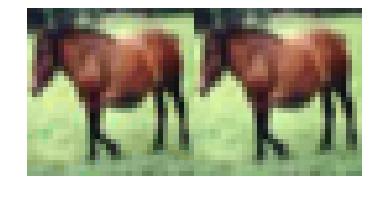

In [343]:
plt.imshow(np.hstack((reconstruction,im/255)))
plt.axis('off')

In [655]:
(reconstruction-im/255).sum()

4.3326475325992995

In [589]:
batch=color.rgb2lab(trainloader.dataset.data[7:12]/255)

In [11]:
def bins2lab(bin_rep,L=None):
    #takes bins representation of an image and returns rgb if Lightness is provided. Else only ab channel
    mbsize=1 if len(bin_rep.shape)==3 else bin_rep.shape[0]
    size=bin_rep.shape[2] if len(bin_rep.shape)==4 else bin_rep.shape[1]
    ab=bins[bin_rep.flatten()].reshape(mbsize,size,-1,2)
    if not L is None:
        ab=np.concatenate((L.reshape(mbsize,size,-1,1),ab),3)
    
    if len(bin_rep.shape)==3:
        ab=ab[0]
    return ab

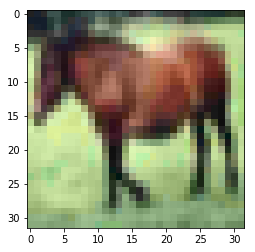

In [676]:
plt.imshow(color.lab2rgb(bins2lab(image2bins(batch[0,:,:,1:]),batch[0,:,:,:1])))

In [678]:
bins2lab(image2bins(batch[:,:,:,1:]),batch[:,:,:,:1]).shape

(5, 32, 32, 3)

In [632]:
batch.shape

(5, 32, 32, 3)

In [162]:
from scipy.ndimage.interpolation import zoom

In [20]:
c=nn.CrossEntropyLoss()
dis=torch.from_numpy(np.random.randint(0,274,(2,274,64,64)))
dis=nn.Softmax(1)(dis.double())
realbins=torch.from_numpy(np.random.randint(0,274,(2,256,256)))

In [21]:
realbins.max()

tensor(273, dtype=torch.int32)

In [44]:
c(dis,realbins.long())

tensor(5.6139, dtype=torch.float64)

In [96]:
realbins=zoom(realbins,(1,.25,.25),order=0)

In [96]:
im=trainloader.dataset.data[7]/255
lab = color.rgb2lab(im)
#x = torch.from_numpy(lab)

In [99]:
im=plt.imread('places-test/Places365_val_%08d.jpg'%33)/255
lab = color.rgb2lab(im)
x = torch.from_numpy(lab)

In [97]:
horsebin=ab2bins(lab[:,:,1:])
downhorsebin=zoom(horsebin,(.25,.25,1),order=0)
updownhorsebin=zoom(downhorsebin,(4,4,1),order=0)
rec=np.concatenate((lab[:,:,:1],bins2lab(updownhorsebin)),2) #bins2lab(updownhorsebin,lab[:,:,:1])
rgbrec=color.lab2rgb(rec)


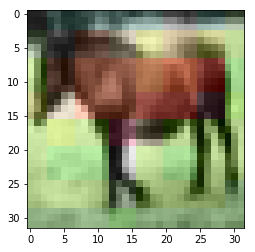

In [98]:
plt.imshow(rgbrec)

In [39]:
updownhorsebin.shape,x.shape

((1, 32, 32), torch.Size([32, 32, 3]))

In [24]:
firstlab=zoom(bins2lab(downhorsebin),(4,4,1),order=3)
recfirst=np.concatenate((lab[:,:,:1],firstlab),2) #bins2lab(updownhorsebin,lab[:,:,:1])
rgbfirst=color.lab2rgb(recfirst)
rgbfirst.shape
#firstlab.shape

(256, 256, 3)

In [25]:
abs(im-rgbrec).mean(),abs(im-rgbfirst).mean()

(0.021833235278297513, 0.015570629738250893)

Best method:
* (Downsample bin representation)
* convert to ab space
* upsampling
* concatenate with L channel
* convert to RGB

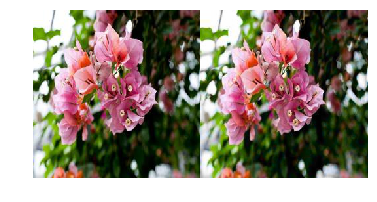

In [121]:
#plt.figure(figsize=(18,9))
plt.imshow(np.hstack((im,rgbfirst)))
plt.axis('off')
#plt.title('Demonstration of sufficient bottelneck dimensionality')
#plt.savefig('figures/bottelneckdemo.pdf')
plt.show()

In [26]:
g.load_state_dict(torch.load('weights/class-test.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [28]:
rose=g(torch.from_numpy(lab[:,:,:1].reshape(1,1,256,256)/100-.5).float())

In [29]:
#rosebin=torch.from_numpy(downhorsebin.reshape(1,64,64)).cuda().long()
rosebin=torch.from_numpy(downhorsebin.reshape(1,64,64)).long()


In [30]:
wouldlike=rose.argmax(1)

In [44]:
onehot=torch.zeros(rose.shape)#.cuda()
onehot[:,wouldlike[0],:,:]=1
onehot.sum(1)

tensor(9.)

In [41]:
nn.CrossEntropyLoss()(onehot,wouldlike)

tensor(4.6680)

In [147]:
nn.CrossEntropyLoss()(rose,rose.argmax(1))

tensor(4.8769, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [107]:
loss = nn.CrossEntropyLoss(reduction='mean')
input = torch.zeros(1, 10, requires_grad=False)
target = torch.empty(1, dtype=torch.long).random_(10)
#input[:,target]=1#,target,input
#input

In [108]:
input[np.arange(1),target]=1
input

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

$$\text{loss}(x, class) = weight[class] \left(-x[class] + \log\left(\sum_j \exp(x[j])\right)\right)$$
$$\text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
                   = -x[class] + \log\left(\sum_j \exp(x[j])\right)$$

In [89]:
ro=ab2bins(torch.from_numpy(lab[:,:,1:]))

In [4]:
hist=np.load('resources/hist_val.npy')

In [21]:
#reproduce histogram:
inthist=np.ceil(hist).astype('int')
histo=[]
for i in range(len(inthist)):
    histo.extend([i]*inthist[i])
histo=np.array(histo)
histo

array([  0,   1,   2, ..., 272, 272, 273])

In [1]:
from sklearn.utils import class_weight

In [23]:
weights=class_weight.compute_class_weight('balanced',np.arange(len(hist)),histo)

In [27]:
np.save('resources/class-weights.npy',weights)

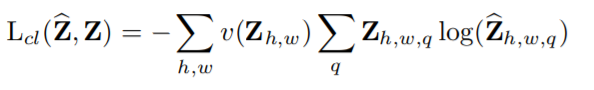

In [363]:
class softCossEntropyLoss(nn.Module):
    def __init__(self,weights=None,device=torch.device('cpu')):
        '''
        weights shape: (Q,)
        '''
        super(softCossEntropyLoss,self).__init__()
        self.weights=(torch.Tensor(weights,device=device) if type(weights)==np.ndarray else weights.to(device)) if not weights is None else None
        
    def forward(self,output,labels):
        '''
        output shape: (batch_size,channels,dim1,dim2)
        labels shape: (batch_size,channels,dim1,dim2) <-- from one hot encoded gaussian filtered 
        returns multinomial cross entropy loss
        '''
        if self.weights is None:
            return -torch.sum(torch.sum(labels*torch.log(output),1),(1,2))        
        else:
            return -torch.sum((self.weights[None,:,None,None]*labels).sum(1)*torch.sum(labels*torch.log(output),1),(1,2))

In [364]:
onehot=torch.empty(3).random_(2)
weights=torch.empty(2,3,2,2).random_(10)

In [370]:
inp=torch.empty(2,10,8,8).random_(4)+1
la=torch.empty(2,10,8,8).random_(4)+1
w=torch.empty(274).random_(2)
l=softCossEntropyLoss()


tensor(310.5929, grad_fn=<MeanBackward2>)

In [21]:
ou=(weights*onehot[None,:,None,None]).sum(1)
ou.shape

torch.Size([2, 2, 2])

In [70]:
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*np.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter


In [71]:
get_gaussian_kernel(3,2,1)

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [55]:
bins=np.load('resources/bins.npy')

In [56]:
def distanceSquaredMatrix(A,B):
    return np.sum(np.square(A[:,None]-B),axis=2)
def K(X1,X2,sig=5):
    dist=distanceSquaredMatrix(X1,X2)
    kernel=np.zeros(dist.shape)
    cutoff=2*sig*np.log(10) #0 when kernel function would be smaller than 0.01
    kernel[dist<cutoff]=np.exp(-dist[dist<cutoff]/(2*sig))
    return kernel

In [148]:
200/2/np.log(10) 

43.42944819032518

In [67]:
coord=np.vstack((xv.ravel(),yv.ravel())).T
coord.shape

(529, 2)

In [68]:
soft=(K(bins,bins,45))

In [69]:
tsoft=torch.from_numpy(soft)

In [70]:
torch.save(tsoft,'resources/smooth_onehot.pt')

In [71]:
tsoft[:,torch.from_numpy(np.random.randint(0,len(soft),(3,32,32))).long()].transpose(0,1).shape

torch.Size([3, 274, 32, 32])

In [74]:
np.count_nonzero(soft,1)[118]

9

In [75]:
soft[118]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [117]:
def bin_sorter(ab):
    return np.round(ab/10)*10

In [121]:
bin_sorter(np.array([0.5,-5.9]))

array([  0., -10.])

In [214]:
g.load_state_dict(torch.load('weights/soft-overfit.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [190]:
testim=None
for i , batch in enumerate(trainloader):
    testim,_ =batch
    break

In [192]:
def norm(im):
    image=np.transpose(im,(0,3,2,1))
    image=np.transpose(color.rgb2lab(image),(0,3,2,1))
    return torch.from_numpy((image+np.array([0,128,128])[None,:,None,None])/np.array([100,255,255])[None,:,None,None]).float()

In [215]:
gba=g(norm(testim)[:,:1,:,:])

In [4]:
import torch.nn.functional as F

In [100]:
x2=torch.unsqueeze(x,0)
horsebin=ab2bins(x2[:,:,:,1:])
downhorsebin=F.interpolate(horsebin.float(),scale_factor=(.25,.25))
abdownhorse=torch.from_numpy(bins2lab(downhorsebin.long())).transpose(3,1)
updownhorsebin=F.interpolate(abdownhorse,scale_factor=(4,4),mode='bilinear')
rec=torch.cat((x2[:,:,:,:1],updownhorsebin.transpose(3,1)),dim=3) #bins2lab(updownhorsebin,lab[:,:,:1])
rgbrec=color.lab2rgb(rec[0])


In [101]:
updownhorsebin.shape,abdownhorse.shape,downhorsebin.shape,x2.shape

(torch.Size([1, 2, 256, 256]),
 torch.Size([1, 2, 64, 64]),
 torch.Size([1, 1, 64, 64]),
 torch.Size([1, 256, 256, 3]))

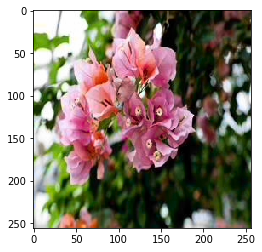

In [102]:
plt.imshow(rgbrec)

In [4]:
from models.unet import unet

In [24]:
u=unet(True,.25,classes=274)
u.load_state_dict(torch.load('weights/notsosmooth.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
im=plt.imread('places-test/Places365_val_%08d.jpg'%33)/255
lab = color.rgb2lab(im).transpose((2,1,0))
x = torch.unsqueeze(torch.from_numpy(lab),0)
L=x[:,:1,...].float()

In [28]:
out=u(L)

In [29]:
out.shape

torch.Size([1, 274, 256, 256])

In [30]:
np.bincount(out.argmax(1).flatten()).argmax()

118

In [46]:
x=out[0,:,20,20].detach().numpy()

Text(0.5, 1.0, '0.9995266')

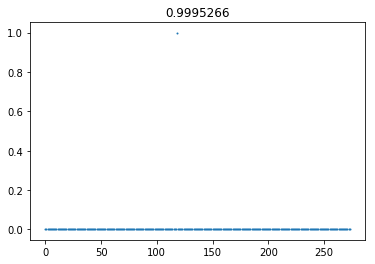

In [53]:
plt.scatter(np.arange(274),x,s=1)
plt.title(x.max())

In [32]:
out.sum(1)

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],
       grad_fn=<SumBackward2>)

In [182]:
out

tensor([[[[0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0004, 0.0003],
          [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0004, 0.0003],
          [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
          ...,
          [0.0003, 0.0004, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
          [0.0003, 0.0004, 0.0003,  ..., 0.0003, 0.0004, 0.0003],
          [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003]],

         [[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0001, 0.0002, 0.0001,  ..., 0.0002, 0.0002, 0.0002],
          ...,
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0001, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],

         [[0.0003, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0003, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0003, 0.0004, 0.0003,  ..., 0

In [5]:
from models.richzhang import richzhang

In [23]:
m=richzhang()
m.load_state_dict(torch.load('weights/CCl.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [24]:
import matplotlib.pyplot as plt
from skimage import color
im=plt.imread('places-test/Places365_val_%08d.jpg'%33)/255
lab = color.rgb2lab(im).transpose((2,1,0))
x = torch.unsqueeze(torch.from_numpy(lab),0)
L=x[:,:1,...].float()

In [25]:
out=m(L)

(array([  3.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,  12.,   0., 186.,   0., 185.,   0., 388.,   3.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,  32.,   0.,  60.,   0.,  73.,   0., 104., 429.,   0.,  79.,
          0., 139.,   0.,  45.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  43.,  58.,   0.,  64.,
          0.,  90.,   0.,  60.,   0., 126.,   0., 346.,  11.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   3.,   0., 127.,   0.,  39.,  35.,   0., 269.,   0., 390.,
          0.,  78.,   0., 250.,   0.,  73.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,  55.,   0.,   0.,   2.,   0.,   1.,   0., 127.,
          0.,  12.,   0.,   9.,   1., 

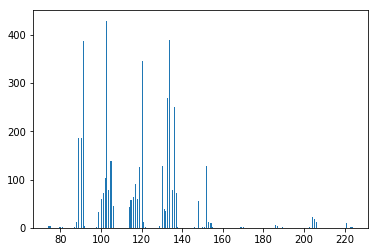

In [26]:
plt.hist(out.argmax(1).numpy().flatten(),bins=274)

In [12]:
np.argsort(np.bincount(out.argmax(1).numpy().flatten()))

array([  0, 189, 107, 108, 109, 110, 111, 112, 113, 188, 185, 184, 183,
       182, 181, 180, 179, 122, 190, 123, 191, 203, 200,  86,  87, 199,
       198, 197, 196,  92,  93,  94,  95,  96,  97,  98, 195, 194, 193,
       192, 167, 124, 126, 149, 150, 151, 170, 169, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 171, 125, 147, 145, 127,
       128, 129, 178, 177, 176, 175, 174, 173, 172, 138, 139, 140, 141,
       142, 143, 144, 146,  83,  84,  81,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  21,  82,
        20,  18,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  19,  40,  39,  42,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73, 202, 201,  77,  78,  79,
        80,  41,  61,  62,  59,  43,  44,  45,  46,  47,  48,  49,  60,
        50,  52,  53,  54,  55,  56,  57,  58,  51, 168, 154, 132,  76,
       204,  88, 121,  85, 131, 187, 148, 186, 153,  74, 152,  9

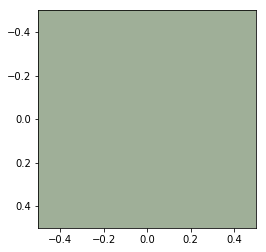

In [17]:
bins=np.load('resources/bins.npy')
ab=bins[103]
plt.imshow(color.lab2rgb(np.array([70,ab[0],ab[1]]).reshape(1,1,3)))

In [33]:
from functions import ab2bins,bins2lab

In [153]:
bins[out.argmax(1)].shape

(1, 64, 64, 2)

In [20]:
from scipy.ndimage.interpolation import zoom

In [29]:
lab=np.concatenate((torch.unsqueeze(torch.squeeze(L,1),3).numpy(),zoom(bins[out.argmax(1)],(1,4,4,1))),3)[0]
ab_l=np.concatenate((torch.unsqueeze(torch.squeeze(torch.ones_like(L)*100,1),3).numpy(),zoom(bins[out.argmax(1)],(1,4,4,1))),3)[0]


C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 611 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


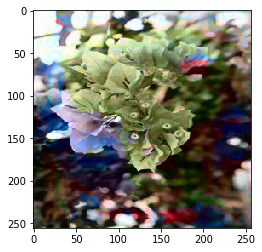

In [31]:
plt.imshow(color.lab2rgb(lab))

In [34]:
(bins2lab(torch.unsqueeze(out,4).argmax(1).detach().cpu().numpy())).max((1,2))

array([[0.7372549 , 0.85490196]])

In [35]:
L.shape

torch.Size([1, 1, 256, 256])

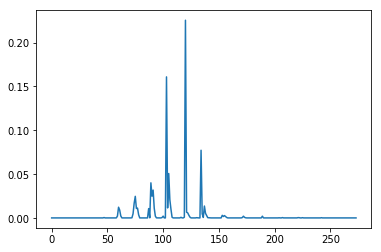

In [36]:
plt.plot(np.arange(274),out[0,:,30,30].detach().numpy())

In [64]:
binrep=None
real=None

In [37]:
from train_classification import *

In [86]:
#optimizer
device=torch.device('cpu')
classifier=m
optimizer=optim.Adam(classifier.parameters())
weights=np.load('resources/class-weights.npy')
weighted_loss=False
#criterion = nn.CrossEntropyLoss(weight=weights).to(device) if weighted_loss else nn.CrossEntropyLoss().to(device)
criterion = softCossEntropyLoss(weights=weights,device=device) if weighted_loss else softCossEntropyLoss(weights=None,device=device)
#additional gan loss: l1 loss
#l1loss = nn.L1Loss().to(device)
loss_hist=[]
#soft_onehot = torch.load('resources/onehot.pt',map_location=device)
soft_onehot = torch.load('resources/smooth_onehot.pt',map_location=device)
dataset=0
mode=0

classifier.train()
#crit.train()
# run over epochs
for i,(image,_) in enumerate(trainloader):
    batch_size=image.shape[0]
    if dataset == 0: #cifar 10
        image=np.transpose(image,(0,3,2,1))
        image=np.transpose(color.rgb2lab(image),(0,3,2,1))
        image=torch.from_numpy((image-np.array([50,0,0])[None,:,None,None])).float()
    X=image[:,:1,:,:].to(device) #set X to the Lightness of the image
    image=image[:,1:,:,:].to(device) #image is a and b channel

    #----------------------------------------------------------------------------------------
    ################################### Model optimization ##################################
    #----------------------------------------------------------------------------------------
    #clear gradients
    optimizer.zero_grad()
    #softmax activated distribution
    model_out=classifier(X).double()
    #create bin coded verion of ab ground truth
    binab=ab2bins(image)
    if mode==0:
        #print(binab.shape)
        binab=F.interpolate(torch.unsqueeze(binab.float(),dim=1),scale_factor=(.25,.25)).long()
        #binab=zoom(binab.cpu(),(1,.25,.25),order=0)
        #binab=torch.from_numpy(binab).long().to(device)
    binab=torch.squeeze(binab,1)#.long()
    #lookup table for soft encoded one hot vectors
    #print('ground truth',np.bincount(binab.detach().cpu().numpy().flatten()))
    #print('output',np.bincount(model_out.detach().cpu().numpy().argmax(1).flatten()))
    binab=soft_onehot[:,binab].transpose(0,1).double()
    binrep=binab.clone()
    real=X.clone()
    print('done')
    #calculate loss 
    #print(model_out.shape,binab.shape)
    loss=criterion(model_out,binab).mean(0)
    print(loss,criterion(model_out,model_out).mean(0),criterion(binab,binab).mean(0))

done
tensor(719.1479, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(258.9657, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(nan, dtype=torch.float64)
done
tensor(698.6792, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(259.1193, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(nan, dtype=torch.float64)
done
tensor(722.4785, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(260.2599, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(nan, dtype=torch.float64)
done
tensor(675.3829, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(260.9577, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(nan, dtype=torch.float64)
done
tensor(697.5448, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(259.9122, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(nan, dtype=torch.float64)
done
tensor(719.5347, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(261.1180, dtype=torch.float64, grad_fn=<MeanBackward2>) tensor(nan, dtype=torch.float64)
done
tensor(782.

KeyboardInterrupt: 

In [100]:
(np.bincount(torch.log(binrep+1e-16).numpy().flatten().astype(int)+int(36e3)))

135680

In [74]:
bins[binrep.numpy().argmax(1)[:1]].shape,real.shape,(torch.unsqueeze(real[0],2).shape)

((1, 8, 8, 2), torch.Size([256, 1, 32, 32]), torch.Size([1, 32, 1, 32]))

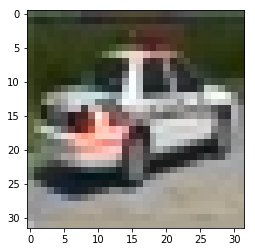

In [84]:
i=53
plt.imshow(color.lab2rgb(np.concatenate((50+torch.unsqueeze(real[i],3).numpy(),zoom(bins[binrep.numpy().argmax(1)[i:i+1]],(1,4,4,1))),3)[0]))

In [76]:
onehot=torch.load('resources/smooth_onehot.pt')

In [21]:

onehot[118]=torch.ones(274)*.329
onehot[:,118]=torch.ones(274)*.329
onehot[118][118]=1.

In [22]:
torch.save(onehot,'resources/smooth_onehot.pt')

In [86]:
onehot

tensor([[1.0000, 0.3292, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3292, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.3292],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3292, 1.0000]],
       dtype=torch.float64)

In [80]:
np.load('resources/class-weights.npy').shape

(274,)

In [81]:
onehot.shape

torch.Size([274, 274])

In [87]:
torch.save(torch.from_numpy(np.identity(274)),'resources/onehot.pt')

In [3]:
torch.load('resources/binmap.pt')

tensor([[118, 119, 120, 121, 122, 123, 124, 125, 126, 127,  -1,  -1,  -1,  -1,
          -1,  -1, 112, 113, 114, 115, 116, 117],
        [134, 135, 136, 137, 138, 139, 140, 141, 142, 143,  -1,  -1,  -1,  -1,
          -1,  -1, 128, 129, 130, 131, 132, 133],
        [151, 152, 153, 154, 155, 156, 157, 158, 159, 160,  -1,  -1,  -1,  -1,
          -1, 144, 145, 146, 147, 148, 149, 150],
        [168, 169, 170, 171, 172, 173, 174, 175, 176,  -1,  -1,  -1,  -1,  -1,
          -1, 161, 162, 163, 164, 165, 166, 167],
        [185, 186, 187, 188, 189, 190, 191, 192, 193,  -1,  -1,  -1,  -1,  -1,
         177, 178, 179, 180, 181, 182, 183, 184],
        [202, 203, 204, 205, 206, 207, 208, 209, 210,  -1,  -1,  -1,  -1,  -1,
         194, 195, 196, 197, 198, 199, 200, 201],
        [219, 220, 221, 222, 223, 224, 225, 226, 227,  -1,  -1,  -1,  -1,  -1,
         211, 212, 213, 214, 215, 216, 217, 218],
        [237, 238, 239, 240, 241, 242, 243, 244, 245,  -1,  -1,  -1,  -1, 228,
         229, 230,